In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [14]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [30]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Find the latest date of record
latest = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(f"The last date of record is {latest}.")

latest = datetime.strptime(latest, '%Y-%m-%d')

# Date 12 months before the last date of record
date_start_query = (latest - dt.timedelta(days=365))
print(f"12 Months Before, would be {date_start_query}.")

# Save the query results as a Pandas DataFrame and set the index to the date column
date_prcp = pd.read_sql("select date, prcp from measurement \
                        where date >= '2016-08-23';", conn).set_index("date")



# Sort the dataframe by date
date_prcp.sort_values("date", inplace=True)
date_prcp.head(10)

date_prcp_avg = date_prcp.groupby(["date"]).mean()
date_prcp_avg.head(5)




The last date of record is 2017-08-23.
12 Months Before, would be 2016-08-23 00:00:00.


,prcp
date,
2016-08-23,0.451667
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000


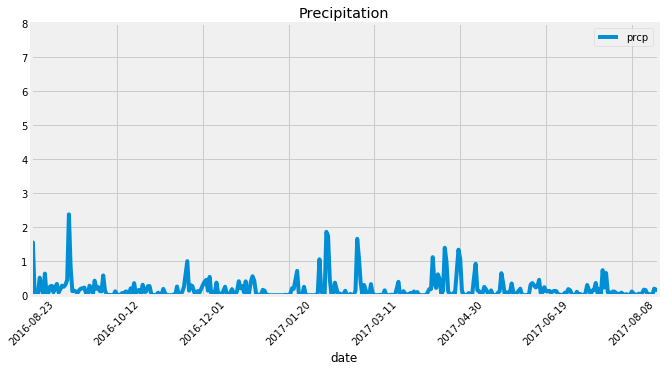

In [36]:
# Use Pandas Plotting with Matplotlib to plot the data

date_prcp_avg.plot(figsize=(10,5),ylim=(0,8),title=f'Precipitation',\
                  label="Precipitation",rot=45)
plt.show()

In [38]:
# Use Pandas to calcualte the summary statistics for the precipitation data
stats = date_prcp.describe()
stats

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [84]:
# Design a query to show how many stations are available in this dataset?
#Set up Stations Dataset

stations = pd.read_sql("select * from measurement", conn)
stations.head(10)

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
5,6,USC00519397,2010-01-07,0.06,70.0
6,7,USC00519397,2010-01-08,0.00,64.0
7,8,USC00519397,2010-01-09,0.00,68.0
8,9,USC00519397,2010-01-10,0.00,73.0
9,10,USC00519397,2010-01-11,0.01,64.0


In [63]:
station_count = pd.read_sql("select count(station) as Station_Count from station", conn)
station_count

,Station_Count
0,9


In [72]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = stations.station.value_counts(ascending=False)
station_activity

USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: station, dtype: int64

In [73]:
print("The station with the most activity is USC00519281")

The station with the most activity is USC00519281


In [83]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

lowest_temp = stations.loc[stations['station'] == "USC00519281"].tobs.min()
highest_temp = stations.loc[stations['station'] == "USC00519281"].tobs.max()
average_temp = stations.loc[stations['station'] == "USC00519281"].tobs.mean()

print(lowest_temp,highest_temp,round(average_temp,4))

54.0 85.0 71.6638


In [97]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
twelve_month_tobs = pd.read_sql("select date, tobs from measurement \
                        where date >= '2016-08-23' and station = 'USC00519281' ;", conn)
twelve_month_tobs.head()

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


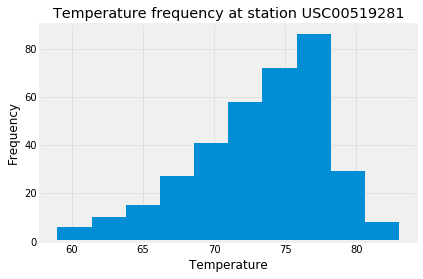

In [96]:
plt.hist(twelve_month_tobs.tobs)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Temperature frequency at station USC00519281") 
plt.grid(linestyle='-', linewidth='0.5', color='lightgrey')

In [99]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2014-09-02', '2014-09-17'))

[(68.0, 77.31818181818181, 85.0)]


In [109]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
weather_trip = (calc_temps('2014-09-02', '2014-09-17'))
weather_trip

[(68.0, 77.31818181818181, 85.0)]

Text(0.5, 1.0, 'Trip average temperature')

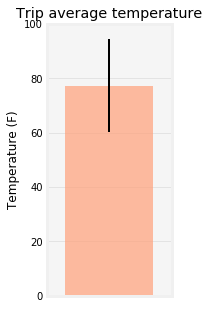

In [113]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize=(2,5))
plt.bar(0, weather_trip[0][1], color="lightsalmon", width=1.4, 
        alpha=0.7, yerr=weather_trip[0][2]-weather_trip[0][0], error_kw={"linewidth":2})
plt.gca().set_facecolor("whitesmoke")
plt.grid(linestyle='-', linewidth='0.5', color='lightgrey')
plt.gca().set_axisbelow(True)
plt.gca().set_xticks([])
plt.xlim((-1, 1))
plt.ylim((0, 100))
plt.ylabel("Temperature (F)")
plt.title("Trip average temperature")



In [114]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# Average rainfall per weather station during the range of dates
start_date_dt = dt.datetime.strptime('2014-09-02', '%Y-%m-%d')
end_date_dt = dt.datetime.strptime('2014-09-17', '%Y-%m-%d')

session.query(Measurement.station, func.avg(Measurement.prcp)). \
            filter(Measurement.date.between(start_date_dt, end_date_dt)). \
            group_by(Measurement.station). \
            order_by(func.avg(Measurement.prcp).desc()).all()

[('USC00516128', 0.24750000000000003),
 ('USC00519281', 0.12066666666666666),
 ('USC00513117', 0.06416666666666666),
 ('USC00519523', 0.05599999999999999),
 ('USC00514830', 0.05),
 ('USC00519397', 0.03142857142857143),
 ('USC00511918', 0.0007692307692307692),
 ('USC00517948', 0.0)]